## Redes neuronales II. PyTorch
___

#### Exercise 1
---
Experimenta con el número de neuronas de la capa oculta del modelo

##### GLOBALS

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

NORM = True
GPU = False

##### LOADING DATA

In [2]:
# temperaturas ºC
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]

# temperaturas en escala desconocida (unknown)
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# convertimos en matrices añadiendo nueva dimensión en el eje 1
t_c = torch.tensor(t_c).unsqueeze(1) 
t_u = torch.tensor(t_u).unsqueeze(1)

# splitting
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

# training dataset
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

# validation dataset
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

# move to GPU
if GPU:
    train_t_u = train_t_u.cuda()
    train_t_c = train_t_c.cuda()
    val_t_u = val_t_u.cuda()
    val_t_c = val_t_c.cuda()

# normalización (si es necesaria)
if NORM:
    train_t_un = 0.1 * train_t_u
    val_t_un = 0.1 * val_t_u
else:
    train_t_un = train_t_u
    val_t_un = val_t_u

##### MODELO

In [3]:
seq_model = nn.Sequential(
            nn.Linear(1, 8),
            nn.Tanh(),
            nn.Linear(8, 1))
if GPU:
    seq_model.cuda()

##### TRAINING LOOP

In [4]:
def training_loop(n_epochs, optimizer, model, loss_fn, 
                  t_u_train, t_u_val, t_c_train, t_c_val, 
                  output=True):
    t_loss = torch.zeros([n_epochs+1, 2])
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train) # usamos el modelo suministrado
        loss_train = loss_fn(t_p_train, t_c_train)  # calcula el error 
        
        optimizer.zero_grad()  # inicializa los gradientes
        loss_train.backward()        # calcula los gradientes
        optimizer.step()       # actualiza los parámetros
        
        # validación
        with torch.no_grad():
            t_p_val = model(t_u_val) 
            loss_val = loss_fn(t_p_val, t_c_val)  
            
        t_loss[epoch] = torch.tensor([loss_train, loss_val])
        
        if output and (epoch==1 or epoch%1000==0):
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                    f" Validation loss {loss_val.item():.4f}")
    return t_loss

##### TRAINING THE MODEL

In [5]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <-- parameters del modelo
t_loss = training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,       # <-- ANN model
    loss_fn=nn.MSELoss(),
    t_u_train=train_t_un,
    t_u_val=val_t_un,
    t_c_train=train_t_c,
    t_c_val=val_t_c)

Epoch 1, Training loss 163.6395, Validation loss 234.0281
Epoch 1000, Training loss 6.2167, Validation loss 3.0337
Epoch 2000, Training loss 5.4808, Validation loss 1.3483
Epoch 3000, Training loss 3.2339, Validation loss 0.3915
Epoch 4000, Training loss 2.4090, Validation loss 0.1217
Epoch 5000, Training loss 2.1814, Validation loss 0.1069


##### PLOTTING ERROR

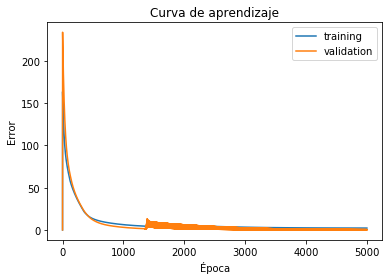

In [6]:
from matplotlib import pyplot as plt

t_x = torch.arange(t_loss.size()[0])
plt.plot(t_loss[:,0].detach().numpy(), label = 'training') # detach().numpy() porque tiene gradientes
plt.plot(t_loss[:,1], label = 'validation') # no tiene gradientes. No necesitamos convertirlo
plt.title(f"Curva de aprendizaje")
plt.ylabel("Error")
plt.xlabel("Época")
plt.legend()
plt.show()

##### PLOTTING MODEL & PREDICTION

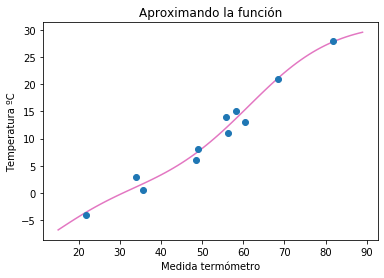

In [7]:
t_x = torch.arange(15, 90).unsqueeze(1).float()

if GPU:
    t_x = t_x.cuda()
    
if NORM:
    t_nx = 0.1*t_x # normalize
else:
    t_nx = t_x

t_p = seq_model(t_nx) # predictions

if GPU:
    t_p = t_p.cpu()
    t_x = t_x.cpu()

plt.plot(t_x, t_p.detach().numpy(), '#e377c2', zorder=1) # visualiz
plt.scatter(t_u, t_c, zorder=2)

plt.title("Aproximando la función")
plt.ylabel("Temperatura ºC")
plt.xlabel("Medida termómetro")
plt.show()